Here we roughly reproduce the results of the paper
[Simulating the Sycamore quantum supremacy circuits - Pan & Zhang](https://scirate.com/arxiv/2103.03074). 
There are of course many practical aspects of actually performing the contraction that we ignore here,
instead just investigating the contraction complexity of the core task of computing a single marginal
probability distribution of 21 qubits (enough to generate a slice of >2 million correlated amplitudes).

In [1]:
%config InlineBackend.figure_formats = ['svg']
import quimb.tensor as qtn
import cotengra as ctg

Load the circuit:

In [2]:
circ = qtn.Circuit.from_qasm_file('circuit_n53_m20_s0_e0_pABCDCDAB.qsim')

Instantiate a path optimizer:

In [5]:
opt = ctg.HyperOptimizer(
    methods=["betweenness", "cmn"],
    slicing_reconf_opts={'target_size': 2**30},  # dynamically slice to W=30
    max_repeats=10,  # sample 1000 contraction trees
    parallel='ray', progbar=True,
)

Rehearse contracting a 21 qubit marginal ([see quimb](https://quimb.readthedocs.io/en/latest/tensor-circuit.html#Generate-samples-from-a-chaotic-circuit)
for what this is doing, the functional difference is we would take *all* the high probability
strings from this marginal rather than a single one):

In [6]:
rehs = circ.sample_chaotic_rehearse(circ.calc_qubit_ordering()[-21:], optimize=opt)

log2[SIZE]: 30.00 log10[FLOPs]: 20.55: 100%|██████████| 10/10 [01:50<00:00, 11.10s/it]


Retrieve the (dynamically sliced) contraction tree:

In [7]:
tree = opt.get_tree()

Check the contraction cost / time complexity (n.b. this is half what's displayed
above as in units not specific to real dtypes):

In [8]:
f'{tree.contraction_cost():e}'

'1.755598e+20'

In the paper the total time complexity is reported as $4.51 \times 10^{18}$, so, 
practical efficiency considerations aside (which are not trivial!) this is 
very similar.

In [9]:
len(tree.sliced_inds)

29

We can also look at the optimizer progression:

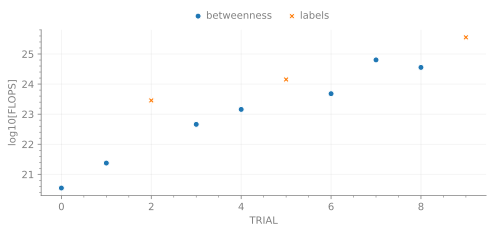

(<Figure size 800x300 with 1 Axes>,
 <Axes: xlabel='TRIAL', ylabel='log10[FLOPS]'>)

In [10]:
opt.plot_trials('flops')

And visualize the actual contraction tree:

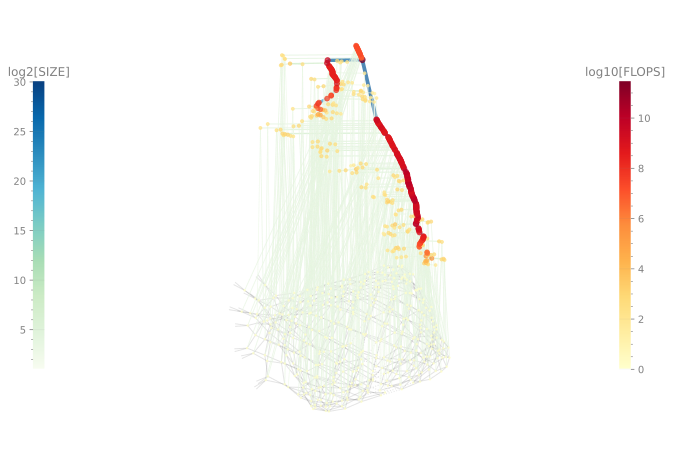

(<Figure size 800x800 with 3 Axes>, <Axes: >)

(deploy pid=30459) [{131, 132, 133, 144, 152, 281, 154, 153, 155, 102, 42, 109, 110, 111, 112, 174, 175, 176, 52, 116, 381}, {197, 200, 137, 138, 94, 160, 161, 162, 163, 117, 118, 119, 181, 182, 125}, {259, 196, 265, 205, 213, 217, 347, 253, 223, 226, 292, 228, 232, 239, 185, 189}, {261, 198, 234, 240, 210, 245, 249, 219, 254, 191}, {332, 270, 336, 337, 338, 278, 279, 280, 357, 358, 300, 301, 302, 316, 317, 318, 319}, {262, 271, 282, 283, 284, 286, 287, 288, 294, 303, 304, 305, 306, 307, 320, 321, 322, 323, 324, 325, 326, 327, 339, 340, 341, 342, 343, 344, 355, 359, 362, 363, 364, 367, 368, 369, 371, 372, 247}, {0, 1, 3, 68, 134, 135, 9, 74, 78, 79, 145, 89, 25, 156, 28, 103, 43, 113, 177}, {267, 268, 269, 273, 275, 276, 297, 298, 299, 310, 311, 312, 313, 186, 314, 315, 333, 206, 334, 335, 214, 348, 349, 350, 351, 352, 353, 354, 356, 229, 360, 361, 235, 366, 251, 255}, {385, 2, 386, 387, 388, 389, 136, 10, 11, 18, 21, 24, 157, 158, 159, 38, 40, 46, 49, 179, 180, 55, 61, 64, 67, 73, 88,

In [11]:
tree.plot_tent(order=True, figsize=(8, 8))